In [6]:
import os
import numpy as np
import pandas as pd
import joblib as jl
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('DummiesV2.csv')

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
targets = ['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué']
X = data.drop(targets, axis=1)
X = pd.DataFrame(data=StandardScaler().fit_transform(X), columns=X.columns)
Y = data[targets].values.argmax(axis=1) # cela réordonne bien les modalités puisque `targets` est ordonnée.
X_train, X_test,Y_train, Y_test = train_test_split(X, Y, test_size=0.3,stratify=Y, random_state=0)

In [9]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import base
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [10]:
def update_fit(estimator,X_train,Y_train,name,retrain=False):
    if not os.path.isfile(name) or retrain:
        fited=estimator.fit(X_train, Y_train)
        jl.dump(fited, name)
    else:
        fited = jl.load(name)
    return(fited)

In [11]:
def plot_confusion_matrix(matrix, classes,
                          normalize=False,
                          cmap=plt.cm.Blues,
                          title=None):

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        title = title if title else "Normalized confusion matrix"
    else:
        title = title if title else "Raw confusion matrix"

    sns.set_style('ticks')
    res = sns.heatmap(matrix,
                      cmap=cmap,
                      cbar=True,
                      square=True,
                      annot=True)

    for _, spine in res.spines.items():
        spine.set_visible(True)

    plt.title(title)
    tick_marks = np.arange(len(classes)) + .5
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Linear SVC équilibrée

In [12]:
lsvc=LinearSVC(multi_class='ovr', dual= False, max_iter=5000, class_weight='balanced')

### step 1: Tunning de l'hyperparamètre C à l'aide de GridSearchCV

on essaye d'avoir une idée du C:
on rappelle que le sens de C est : 'indicateur qui détermine l'influence de la classifcation erronée'

1ère itération: on choisit un ordre de grandeur
au vu du sens de C, on choisit de tester 0.1, 1, 10, 50, 100, 5000 , 1000
comme il s'agit d'un premier ordre d'idée, nous choisissons cv=2

In [13]:
from sklearn.model_selection import StratifiedKFold

In [14]:
dist=dict(C=np.array([10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),1,10,100,1000,10**4,10**5]))
lsvc_ODG=GridSearchCV(lsvc,dist, scoring= 'accuracy', cv=StratifiedKFold(5), verbose=3, refit=True)
lsvc_ODG=update_fit(lsvc_ODG,X_train,Y_train,'LinearSVC_GridSearch_ODG2').best_estimator_

In [15]:
lsvc_ODG

LinearSVC(C=100.0, class_weight='balanced', dual=False, max_iter=5000)

Puisque C vaut 100 , 2 ème itération: 

In [38]:
dist=dict(C=np.array([50,75,100,200,300,400,500]))
lsvc_gs=GridSearchCV(lsvc,dist, verbose=3, cv=StratifiedKFold(5),refit=True)
lsvc_gs=update_fit(lsvc_gs,X_train,Y_train,'LinearSVC_GridSearch_precis')
lsvc_gs=lsvc_gs.best_estimator_

On remarque ici que les 'accuracy' sont très proches si ce n'est égales, on s'arrête donc à ce niveau de précision ie C=75


In [39]:
lsvc_gs

LinearSVC(C=75, class_weight='balanced', dual=False, max_iter=5000)

L'estimateur linear_svc_precis est déjà fit par définition, regardons donc la matrice de confusion sur l'échantillon test

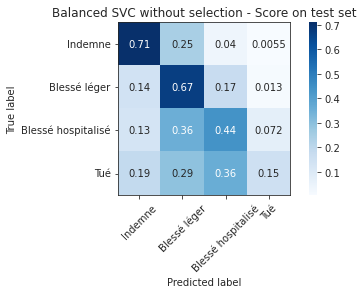

In [18]:
y_hat_svc_gs=lsvc_gs.predict(X_test)
conf = metrics.confusion_matrix(y_hat_svc_gs, Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced SVC without selection - Score on test set');


In [52]:
#accuracy
print('Accuracy :', np.mean(y_hat_svc_gs==Y_test))

Accuracy : 0.6259242492832352


### step 1': Tunning de l'hyperparamètre C à l'aide de RandomizedSearchCV 

On regarde aux environs de 50,500 aussi

In [19]:
from scipy.stats import loguniform
dist=dict(C=loguniform(50,500))
lsvc_r=RandomizedSearchCV(lsvc,n_iter=10, param_distributions=dist,verbose=3,cv=StratifiedKFold(5),refit=True)
lsvc_r=update_fit(lsvc_r,X_train,Y_train,'LinearSVC_RandomizedSearch_ODG2').best_estimator_

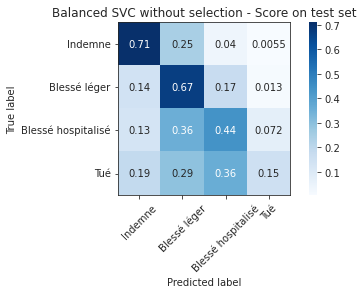

In [20]:
y_hat_svc_rs=lsvc_r.predict(X_test)
conf = metrics.confusion_matrix(y_hat_svc_rs, Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced SVC without selection - Score on test set');


### step 2: séléction de variable grâce à RFECV

#### avec GS

On applique maintenant la méthode RFECV sur notre estimateur LinearSVC optimal (attention il faut le 'unfit' d'abord)

In [40]:
lsvc_rfe=base.clone(lsvc_gs, safe=True)

In [41]:
lsvc_gs=RFECV(lsvc_rfe, cv=StratifiedKFold(2), verbose=3, scoring="accuracy", step=5)
#step = 1 recursif trop trop long (plus d'1h40) on passe a step=5 
#avec step=5 temps de calcul = 32min

In [ ]:
selector_lsvc_gs=update_fit(lsvc_gs,X_train,Y_train,'LinearSVC_C_opt_selecvar')


In [43]:
 lsvc_balanced=selector_lsvc_gs.estimator_

In [ ]:
selected_lsvc = [variable for variable, boolean in zip(X.columns.tolist(), selector_lsvc_gs.support_.tolist()) if boolean]
y_hat_svc1=lsvc_balanced.predict(X_test[selected_lsvc])


In [54]:
print('Accuracy :', np.mean(y_hat_svc1== Y_test))

Accuracy : 0.6265026910115186


In [45]:
#95 variables sélectionnées:
len(selected_lsvc)

95

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


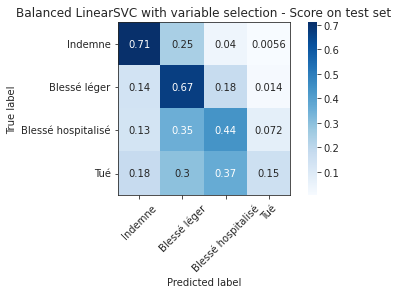

In [47]:
conf = metrics.confusion_matrix(lsvc_balanced.predict(X_test[selected_lsvc]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced LinearSVC with variable selection - Score on test set');

In [ ]:
#on gagne un peu en précision mais pas sur la matrice de confusion 

# LinearSVC non équilibrée

 Les temps de calculs étant relativement longs, nous ferons seulement une optimisation de l'hyperparamètre C sur l'ensemble des variables.

In [48]:
lsvc_u=LinearSVC(multi_class='ovr', dual= False, max_iter=5000)

In [ ]:
dist=dict(C=loguniform(1,1e4))
lsvc_u_r=RandomizedSearchCV(lsvc_u,dist, scoring='accuracy',cv=2, verbose=3)
lsvc2_u_r=update_fit(lsvc_u_r,X_train,Y_train,'LinearSVC_Unbalanced_RandomizedSearch',retrain=True).best_estimator_
lsvc2_u=base.clone(lsvc2_u_r,safe=True)
lsvc2_u=RFECV(lsvc2_u, cv=2, verbose=3, scoring="accuracy", step=5)
selector_lsvc2_u=update_fit(lsvc2_u,X_train,Y_train,'LinearSVC_Unbalanced',)
lsvc2_u=selector_lsvc2_u.estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


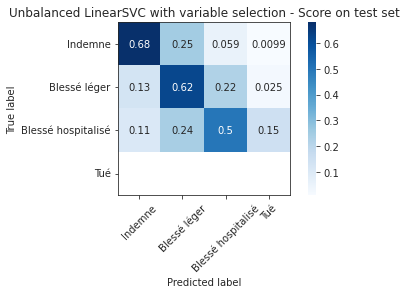

In [63]:

selected_lsvc2_u = [variable for variable, boolean in zip(X.columns.tolist(), selector_lsvc2_u.support_.tolist()) if boolean]
y_hat_lsvc2=lsvc2_u.predict(X_test[selected_lsvc2_u])
conf = metrics.confusion_matrix(y_hat_lsvc2, Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced LinearSVC with variable selection - Score on test set');

In [84]:
#problème les tués sont si mal représentés qu'ils ne sont même pas prédits
sum(y_hat_lsvc2==3)

0

# les tués sont toujours mal classés changeons de mesure

In [ ]:
#dist=dict(C=loguniform(1e-4,1e4))
#lsvc2_r=RandomizedSearchCV(lsvc,dist, scoring='f1_micro',cv=StratifiedKFold(5), verbose=3, refit=True)
#lsvc2=update_fit(lsvc2_r,X_train,Y_train,'LinearSVC_RandomizedSearchf1').best_estimator_
#selector_lsvc2=update_fit(RFECV(lsvc2, cv=StratifiedKFold(5), verbose=3, scoring="f1_micro", step=5),X_train,Y_train,'LinearSVC_f1')
#lsvc2=selector_lsvc2.estimator_

In [ ]:
#selected_lsvc2 = [variable for variable, boolean in zip(X.columns.tolist(), selector_lsvc2.support_.tolist()) if boolean]
#y_hat_lsvc2=lsvc2.predict(X_test[selected_lsvc2])
#conf = metrics.confusion_matrix(y_hat_lsvc2, Y_test)
#plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced LinearSVC with variable selection - Score on test set');

J'ai essayé plusieurs approches pour changer la 'décroissance' de le la performance des prédictions (au niveau de la gravité):
-utilisé le module mord et LogisticIT et LogisticAT malheureursement les résultats sont nettements moins bons, la construction étant opaque pas de marge de manoeuvre pour comprendre l'origine du problème 
-utiliser une autre métrique: le F1 non binaire 
